
## Gesture Recognition Project
By Divya Jayendrakumar Sodha
> ### Problem Statement
As a data scientist at a home electronics company which manufactures state of the art smart televisions, the task here is to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

>The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
>| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

>Each video is a sequence of 30 frames (or images).

>### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.
2. **Model**: To develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. We started by training on a small number of epochs and then proceeded further.
3. **Write up**: This should contain the detailed procedure followed in choosing the final model.

In [ ]:
# Importing the necessary libraries

import numpy as np
import os
from cv2 import resize
from imageio import imread
# from scipy.misc import imread, imresize
from sklearn.model_selection import train_test_split
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
import cv2
import matplotlib.pyplot as plt

In [ ]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, LSTM, GlobalAveragePooling3D, GlobalAveragePooling2D, ConvLSTM2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [ ]:
# extracting Dataset

import zipfile
from google.colab import drive

drive.mount('/content/drive/')

try:
    with zipfile.ZipFile("/content/drive/MyDrive/Upgrad/Deep Learning/CNN_RNN_Assignment/Project_data.zip","r") as zip_ref:
        zip_ref.extractall("/content")
except OSError as e:
    print('Error:', e.strerror)  

Mounted at /content/drive/


In [ ]:
project_folder='/content/Project_data'

##### Plotting

In [ ]:
# function to plot the training/validation accuracies/losses.

def plot_accuracy_and_loss(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Basic Customizable Class with methods for creating generators, training model, etc. 
> 1) Few Initializations methods for path, image properperties and hyperparameters

>2) The overall structure of the generator has been given. In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. 

>3) Generalized method for building model and evaluating it.

>**Note:
Here, we are splitting the train folder for training and validation purpose. We are using the valid folder of dataset to test/evaluate how robust the model is.**

In [ ]:
class ModelBuilderClass():
    
    def initialize_path(self,project_folder):
        data = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.train_doc, self.val_doc = train_test_split(data,test_size=0.1)
        self.test_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'train'
        self.test_path = project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        self.num_test_sequences = len(self.test_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width))
                    
        
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)
        test_generator = self.generator(self.test_path, self.test_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_test_sequences%self.batch_size) == 0:
            test_steps = int(self.num_test_sequences/self.batch_size)
        else:
            test_steps = (self.num_test_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, 
                            validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

        # plot_accuracy_and_loss(history)
        # print(model.evaluate_generator(val_generator))

        # Evaluate the model
        print('Evaluating')
        test_loss, test_acc = model.evaluate_generator(test_generator, test_steps)
        print('\nTest accuracy:', test_acc)
        print('\nTest loss:', test_loss)

        return history

        
    def define_model(self):
        pass

## Sample Model


In [ ]:
class SampleModelConv3D(ModelBuilderClass):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, kernel_size=3, activation='relu', input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Conv3D(32, kernel_size=3, activation='relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.5))

        model.add(Conv3D(64, kernel_size=3, activation='relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.5))
              
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(Dense(self.num_classes,activation='softmax'))

        adam_optimizer = tf.keras.optimizers.Adam()
        model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

>**Note**:
We set the batch size as 32 on the basis of GPU utilization capacity. We kept increasing the batch size until the machine threw an error. 

> Next we are experimenting with image dimesions and frame sizes to decide based on trade off between number of parameters and accuracy.

In [ ]:
trial1=SampleModelConv3D()
trial1.initialize_path(project_folder)
trial1.initialize_image_properties(image_height=128,image_width=128)
trial1.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=5)
trial1_model=trial1.define_model()
print("Total Params:", trial1_model.count_params())
trial1.train_model(trial1_model)

Total Params: 14816901
Epoch 1/5
19/19 [==============================] - ETA: 0s - loss: 2.5959 - categorical_accuracy: 0.2198
Epoch 1: val_loss improved from inf to 1.60076, saving model to model_init_2022-10-1414_34_42.407549/model-00001-2.59587-0.21980-1.60076-0.31343.h5
19/19 [==============================] - 47s 2s/step - loss: 2.5959 - categorical_accuracy: 0.2198 - val_loss: 1.6008 - val_categorical_accuracy: 0.3134 - lr: 0.0010
Epoch 2/5
19/19 [==============================] - ETA: 0s - loss: 1.5583 - categorical_accuracy: 0.2936
Epoch 2: val_loss improved from 1.60076 to 1.58125, saving model to model_init_2022-10-1414_34_42.407549/model-00002-1.55830-0.29362-1.58125-0.34328.h5
19/19 [==============================] - 31s 2s/step - loss: 1.5583 - categorical_accuracy: 0.2936 - val_loss: 1.5813 - val_categorical_accuracy: 0.3433 - lr: 0.0010
Epoch 3/5
19/19 [==============================] - ETA: 0s - loss: 1.4233 - categorical_accuracy: 0.4144
Epoch 3: val_loss improved fro

In [ ]:
trial2=SampleModelConv3D()
trial2.initialize_path(project_folder)
trial2.initialize_image_properties(image_height=128,image_width=128)
trial2.initialize_hyperparams(frames_to_sample=20,batch_size=32,num_epochs=5)
trial2_model=trial2.define_model()
print("Total Params:", trial2_model.count_params())
trial2.train_model(trial2_model)

Total Params: 22189701
Epoch 1/5
19/19 [==============================] - ETA: 0s - loss: 5.4964 - categorical_accuracy: 0.2047
Epoch 1: val_loss improved from inf to 1.60948, saving model to model_init_2022-10-1414_38_12.928898/model-00001-5.49637-0.20470-1.60948-0.20896.h5
19/19 [==============================] - 52s 3s/step - loss: 5.4964 - categorical_accuracy: 0.2047 - val_loss: 1.6095 - val_categorical_accuracy: 0.2090 - lr: 0.0010
Epoch 2/5
19/19 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.1946
Epoch 2: val_loss did not improve from 1.60948
19/19 [==============================] - 38s 2s/step - loss: 1.6094 - categorical_accuracy: 0.1946 - val_loss: 1.6100 - val_categorical_accuracy: 0.1940 - lr: 0.0010
Epoch 3/5
19/19 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.1946
Epoch 3: val_loss improved from 1.60948 to 1.60927, saving model to model_init_2022-10-1414_38_12.928898/model-00003-1.60944-0.19463-1.

In [ ]:
trial3=SampleModelConv3D()
trial3.initialize_path(project_folder)
trial3.initialize_image_properties(image_height=64,image_width=64)
trial3.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=5)
trial3_model=trial3.define_model()
print("Total Params:", trial3_model.count_params())
trial3.train_model(trial3_model)

Total Params: 3282565
Epoch 1/5
19/19 [==============================] - ETA: 0s - loss: 1.7354 - categorical_accuracy: 0.2064
Epoch 1: val_loss improved from inf to 1.60881, saving model to model_init_2022-10-1414_42_47.332881/model-00001-1.73545-0.20638-1.60881-0.17910.h5
19/19 [==============================] - 26s 1s/step - loss: 1.7354 - categorical_accuracy: 0.2064 - val_loss: 1.6088 - val_categorical_accuracy: 0.1791 - lr: 0.0010
Epoch 2/5
19/19 [==============================] - ETA: 0s - loss: 1.5760 - categorical_accuracy: 0.2148
Epoch 2: val_loss improved from 1.60881 to 1.58452, saving model to model_init_2022-10-1414_42_47.332881/model-00002-1.57597-0.21477-1.58452-0.19403.h5
19/19 [==============================] - 25s 1s/step - loss: 1.5760 - categorical_accuracy: 0.2148 - val_loss: 1.5845 - val_categorical_accuracy: 0.1940 - lr: 0.0010
Epoch 3/5
19/19 [==============================] - ETA: 0s - loss: 1.5283 - categorical_accuracy: 0.2483
Epoch 3: val_loss improved from

In [ ]:
trial4=SampleModelConv3D()
trial4.initialize_path(project_folder)
trial4.initialize_image_properties(image_height=64,image_width=64)
trial4.initialize_hyperparams(frames_to_sample=20,batch_size=32,num_epochs=5)
trial4_model=trial4.define_model()
print("Total Params:", trial4_model.count_params())
trial4.train_model(trial4_model)

Total Params: 4888197
Epoch 1/5
19/19 [==============================] - ETA: 0s - loss: 2.4655 - categorical_accuracy: 0.2114
Epoch 1: val_loss improved from inf to 1.60991, saving model to model_init_2022-10-1414_45_16.658978/model-00001-2.46549-0.21141-1.60991-0.19403.h5
19/19 [==============================] - 33s 2s/step - loss: 2.4655 - categorical_accuracy: 0.2114 - val_loss: 1.6099 - val_categorical_accuracy: 0.1940 - lr: 0.0010
Epoch 2/5
19/19 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.2081
Epoch 2: val_loss did not improve from 1.60991
19/19 [==============================] - 33s 2s/step - loss: 1.6094 - categorical_accuracy: 0.2081 - val_loss: 1.6104 - val_categorical_accuracy: 0.1642 - lr: 0.0010
Epoch 3/5
19/19 [==============================] - ETA: 0s - loss: 1.6095 - categorical_accuracy: 0.2081
Epoch 3: val_loss did not improve from 1.60991
19/19 [==============================] - 31s 2s/step - loss: 1.6095 - categorical_accurac

> **Note**
 Following hyper parameters are considered based on above experimentation on image size, frame size, etc :-
 1. image_height=64
 2. image_width=64
 3. frames_to_sample=16
 4. batch_size=32 (As already mentioned above)

 > Here, we tried to keep the parameters in power of 2 since  it is efficient for computation.

## Model 1 - Conv3D 


#### A. Without Augmentation

In [ ]:
class ModelConv3D1(ModelBuilderClass):
    
    def define_model(self):

        model = Sequential()

        model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Conv3D(64, kernel_size=3, activation='relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv3D(128, kernel_size=3, activation='relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))
        model.add(Dropout(0.2))

        model.add(GlobalAveragePooling3D())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.num_classes,activation='softmax'))

        adam_optimizer = tf.keras.optimizers.Adam()
        model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=64,image_width=64)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=40)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 14, 62, 62, 32)    2624      
                                                                 
 conv3d_13 (Conv3D)          (None, 12, 60, 60, 64)    55360     
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 6, 30, 30, 64)    0         
 3D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 6, 30, 30, 64)     0         
                                                                 
 conv3d_14 (Conv3D)          (None, 4, 28, 28, 128)    221312    
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 4, 14, 14, 128)   0         
 3D)                                                  

In [ ]:
print("Total Params:", conv_3d1_model.count_params())
history_model1=conv_3d1.train_model(conv_3d1_model)

Total Params: 708613
Epoch 1/40
19/19 [==============================] - ETA: 0s - loss: 1.6104 - categorical_accuracy: 0.1913
Epoch 1: val_loss improved from inf to 1.56132, saving model to model_init_2022-10-1414_49_28.805966/model-00001-1.61043-0.19128-1.56132-0.23881.h5
19/19 [==============================] - 29s 1s/step - loss: 1.6104 - categorical_accuracy: 0.1913 - val_loss: 1.5613 - val_categorical_accuracy: 0.2388 - lr: 0.0010
Epoch 2/40
19/19 [==============================] - ETA: 0s - loss: 1.5607 - categorical_accuracy: 0.2567
Epoch 2: val_loss improved from 1.56132 to 1.42929, saving model to model_init_2022-10-1414_49_28.805966/model-00002-1.56072-0.25671-1.42929-0.37313.h5
19/19 [==============================] - 27s 1s/step - loss: 1.5607 - categorical_accuracy: 0.2567 - val_loss: 1.4293 - val_categorical_accuracy: 0.3731 - lr: 0.0010
Epoch 3/40
19/19 [==============================] - ETA: 0s - loss: 1.4576 - categorical_accuracy: 0.3641
Epoch 3: val_loss improved fr

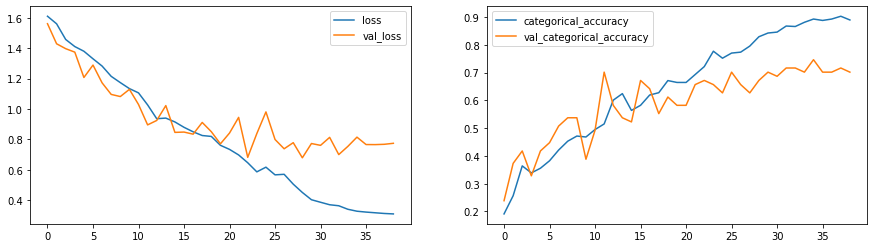

In [ ]:
plot_accuracy_and_loss(history_model1)

#### B. With Augmentation

In [ ]:
conv_3d1b=ModelConv3D1()
conv_3d1b.initialize_path(project_folder)
conv_3d1b.initialize_image_properties(image_height=64,image_width=64)
conv_3d1b.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=40)
conv_3d1b_model=conv_3d1b.define_model()
# conv_3d2b_model.summary()

In [ ]:
print("Total Params:", conv_3d1b_model.count_params())
history_model1b=conv_3d1b.train_model(conv_3d1b_model, augment_data=True)

Total Params: 708613
Epoch 1/40
19/19 [==============================] - ETA: 0s - loss: 1.6078 - categorical_accuracy: 0.2299
Epoch 1: val_loss improved from inf to 1.60281, saving model to model_init_2022-10-1415_08_04.468008/model-00001-1.60781-0.22987-1.60281-0.29851.h5
19/19 [==============================] - 51s 3s/step - loss: 1.6078 - categorical_accuracy: 0.2299 - val_loss: 1.6028 - val_categorical_accuracy: 0.2985 - lr: 0.0010
Epoch 2/40
19/19 [==============================] - ETA: 0s - loss: 1.5773 - categorical_accuracy: 0.2819
Epoch 2: val_loss improved from 1.60281 to 1.57537, saving model to model_init_2022-10-1415_08_04.468008/model-00002-1.57729-0.28188-1.57537-0.25373.h5
19/19 [==============================] - 47s 3s/step - loss: 1.5773 - categorical_accuracy: 0.2819 - val_loss: 1.5754 - val_categorical_accuracy: 0.2537 - lr: 0.0010
Epoch 3/40
19/19 [==============================] - ETA: 0s - loss: 1.4761 - categorical_accuracy: 0.3456
Epoch 3: val_loss improved fr

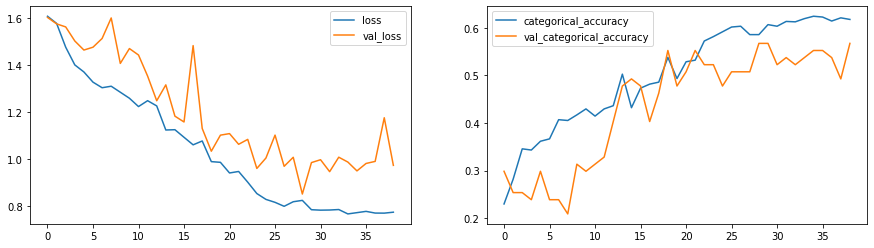

In [ ]:
plot_accuracy_and_loss(history_model1b)

## Model 2 - Conv2D + GRU

In [ ]:
class RNNCNN1(ModelBuilderClass):
    
    def define_model(self):

        model = Sequential()
        model.add(TimeDistributed(
            Conv2D(32, (3,3), activation='relu'), input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(
            MaxPooling2D((2,2)))
        )

        model.add(TimeDistributed(
            Conv2D(64, (3,3), activation='relu'))
        )
        model.add(TimeDistributed(
            MaxPooling2D((2,2)))
        )

        model.add(TimeDistributed(GlobalAveragePooling2D()))
        model.add(TimeDistributed(Dense(64, activation='relu')))

        model.add(GRU(128))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        adam_optimizer = tf.keras.optimizers.Adam(0.002)
        model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=64,image_width=64)
rnn_cnn1.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=40)
rnn_cnn1_model=rnn_cnn1.define_model()
rnn_cnn1_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 16, 62, 62, 32)   896       
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 16, 31, 31, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 16, 29, 29, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 16, 14, 14, 64)   0         
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 16, 64)          

In [ ]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model2=rnn_cnn1.train_model(rnn_cnn1_model)

Total Params: 98693
Epoch 1/40
19/19 [==============================] - ETA: 0s - loss: 1.6126 - categorical_accuracy: 0.1980
Epoch 1: val_loss improved from inf to 1.60431, saving model to model_init_2022-10-1415_42_07.753541/model-00001-1.61264-0.19799-1.60431-0.29851.h5
19/19 [==============================] - 28s 1s/step - loss: 1.6126 - categorical_accuracy: 0.1980 - val_loss: 1.6043 - val_categorical_accuracy: 0.2985 - lr: 0.0020
Epoch 2/40
19/19 [==============================] - ETA: 0s - loss: 1.5936 - categorical_accuracy: 0.2517
Epoch 2: val_loss improved from 1.60431 to 1.56553, saving model to model_init_2022-10-1415_42_07.753541/model-00002-1.59359-0.25168-1.56553-0.25373.h5
19/19 [==============================] - 25s 1s/step - loss: 1.5936 - categorical_accuracy: 0.2517 - val_loss: 1.5655 - val_categorical_accuracy: 0.2537 - lr: 0.0020
Epoch 3/40
19/19 [==============================] - ETA: 0s - loss: 1.5340 - categorical_accuracy: 0.3104
Epoch 3: val_loss improved fro

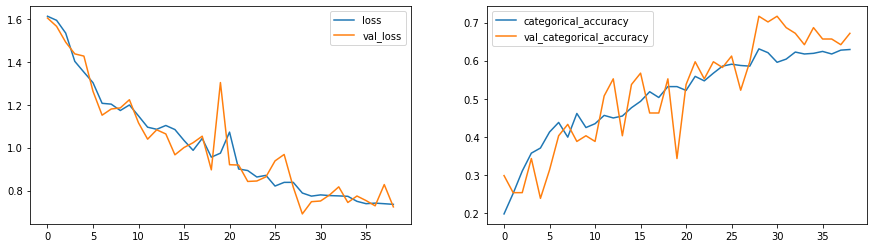

In [ ]:
plot_accuracy_and_loss(history_model2)

##### Model has a  best validation accuracy of 72% and training accuracy of 76% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

## Model 3 - Conv2D + LSTM


#### A. Without Augmentation

In [ ]:
class RNNCNN2(ModelBuilderClass):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Dropout(dropout)))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Dropout(dropout)))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
  
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(lstm_cells))
        model.add(Dropout(0.5))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(0.25))        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        adam_optimizer = tf.keras.optimizers.Adam(lr=0.002)
        model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=64,image_width=64)
rnn_cnn2.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=40)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=64,dense_neurons=64,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 16, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 16, 32, 32, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 16, 32, 32, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 16, 16, 16, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 16, 16, 16, 32)  

In [ ]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model3=rnn_cnn2.train_model(rnn_cnn2_model)

Total Params: 675877
Epoch 1/40
19/19 [==============================] - ETA: 0s - loss: 1.6447 - categorical_accuracy: 0.1879
Epoch 1: val_loss improved from inf to 1.61312, saving model to model_init_2022-10-1416_01_11.718520/model-00001-1.64465-0.18792-1.61312-0.13433.h5
19/19 [==============================] - 77s 1s/step - loss: 1.6447 - categorical_accuracy: 0.1879 - val_loss: 1.6131 - val_categorical_accuracy: 0.1343 - lr: 0.0020
Epoch 2/40
19/19 [==============================] - ETA: 0s - loss: 1.6114 - categorical_accuracy: 0.1980
Epoch 2: val_loss improved from 1.61312 to 1.60988, saving model to model_init_2022-10-1416_01_11.718520/model-00002-1.61141-0.19799-1.60988-0.20896.h5
19/19 [==============================] - 25s 1s/step - loss: 1.6114 - categorical_accuracy: 0.1980 - val_loss: 1.6099 - val_categorical_accuracy: 0.2090 - lr: 0.0020
Epoch 3/40
19/19 [==============================] - ETA: 0s - loss: 1.6101 - categorical_accuracy: 0.1862
Epoch 3: val_loss improved fr

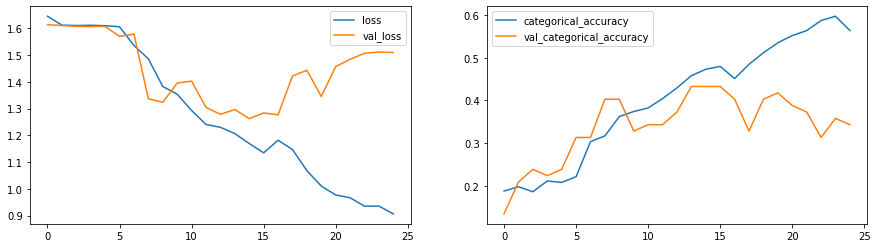

In [ ]:
plot_accuracy_and_loss(history_model3)

#### B. With Augmentation

In [ ]:
rnn_cnn2b=RNNCNN2()
rnn_cnn2b.initialize_path(project_folder)
rnn_cnn2b.initialize_image_properties(image_height=64,image_width=64)
rnn_cnn2b.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=40)
rnn_cnn2b_model=rnn_cnn2b.define_model(lstm_cells=64,dense_neurons=64,dropout=0.25)
# rnn_cnn2b_model.summary()

In [ ]:
print("Total Params:", rnn_cnn2b_model.count_params())
history_model3b=rnn_cnn2.train_model(rnn_cnn2b_model, augment_data=True)

Total Params: 675877
Epoch 1/40
19/19 [==============================] - ETA: 0s - loss: 1.6173 - categorical_accuracy: 0.2307
Epoch 1: val_loss improved from inf to 1.59551, saving model to model_init_2022-10-1416_14_33.656422/model-00001-1.61730-0.23070-1.59551-0.34328.h5
19/19 [==============================] - 57s 3s/step - loss: 1.6173 - categorical_accuracy: 0.2307 - val_loss: 1.5955 - val_categorical_accuracy: 0.3433 - lr: 0.0020
Epoch 2/40
19/19 [==============================] - ETA: 0s - loss: 1.5727 - categorical_accuracy: 0.2794
Epoch 2: val_loss improved from 1.59551 to 1.56788, saving model to model_init_2022-10-1416_14_33.656422/model-00002-1.57268-0.27936-1.56788-0.31343.h5
19/19 [==============================] - 44s 2s/step - loss: 1.5727 - categorical_accuracy: 0.2794 - val_loss: 1.5679 - val_categorical_accuracy: 0.3134 - lr: 0.0020
Epoch 3/40
19/19 [==============================] - ETA: 0s - loss: 1.4733 - categorical_accuracy: 0.3482
Epoch 3: val_loss improved fr

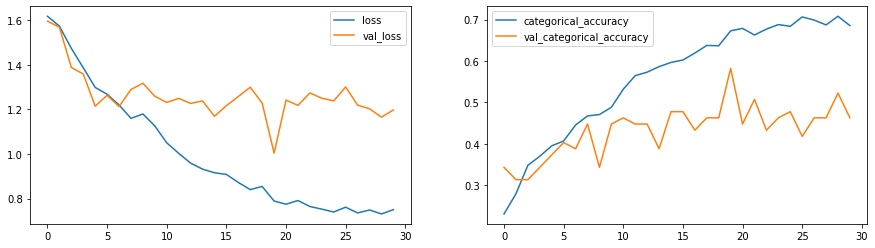

In [ ]:
plot_accuracy_and_loss(history_model3b)

## Model 4 - Transfer Learning using Mobilnet with LSTM and data augmentation


In [ ]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. 
from keras.applications import mobilenet

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderClass):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        # for layer in model.layers:
        #     layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=64,image_width=64)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 2, 2, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 2, 2, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               5

In [ ]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model4=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 1.4345 - categorical_accuracy: 0.3867
Epoch 1: val_loss improved from inf to 1.28836, saving model to model_init_2022-10-1507_57_45.402692/model-00001-1.43452-0.38674-1.28836-0.44776.h5
19/19 [==============================] - 69s 3s/step - loss: 1.4345 - categorical_accuracy: 0.3867 - val_loss: 1.2884 - val_categorical_accuracy: 0.4478 - lr: 0.0010
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 0.7403 - categorical_accuracy: 0.7424
Epoch 2: val_loss improved from 1.28836 to 1.04379, saving model to model_init_2022-10-1507_57_45.402692/model-00002-0.74031-0.74245-1.04379-0.61194.h5
19/19 [==============================] - 49s 3s/step - loss: 0.7403 - categorical_accuracy: 0.7424 - val_loss: 1.0438 - val_categorical_accuracy: 0.6119 - lr: 0.0010
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 0.3190 - categorical_accuracy: 0.8985
Epoch 3: val_loss did not im

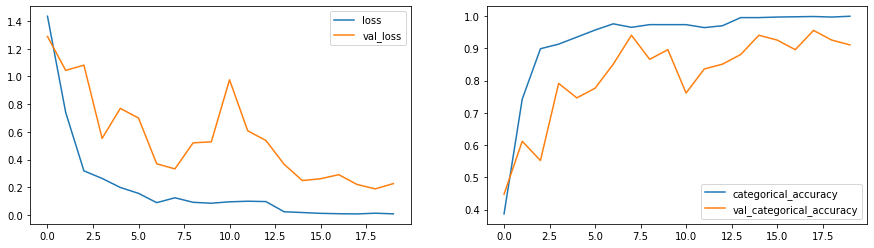

In [ ]:
plot_accuracy_and_loss(history_model4)

## Model 5 - Transfer Learning using Mobilnet with GRU and data augmentation (Final Model)

In [ ]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderClass):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        adam_optimizer = tf.keras.optimizers.Adam()
        model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=64,image_width=64)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 16, 2, 2, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 16, 2, 2, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_3 (GRU)                 (None, 128)              

In [ ]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model5=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 1.3370 - categorical_accuracy: 0.4589
Epoch 1: val_loss improved from inf to 1.27067, saving model to model_init_2022-10-1517_21_04.769472/model-00001-1.33702-0.45889-1.27067-0.44776.h5
19/19 [==============================] - 50s 3s/step - loss: 1.3370 - categorical_accuracy: 0.4589 - val_loss: 1.2707 - val_categorical_accuracy: 0.4478 - lr: 0.0010
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 0.5870 - categorical_accuracy: 0.7819
Epoch 2: val_loss did not improve from 1.27067
19/19 [==============================] - 44s 2s/step - loss: 0.5870 - categorical_accuracy: 0.7819 - val_loss: 1.8649 - val_categorical_accuracy: 0.3284 - lr: 0.0010
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 0.2619 - categorical_accuracy: 0.9119
Epoch 3: val_loss improved from 1.27067 to 0.66945, saving model to model_init_2022-10-1517_21_04.769472/model-00003-0.26190-0.91191-

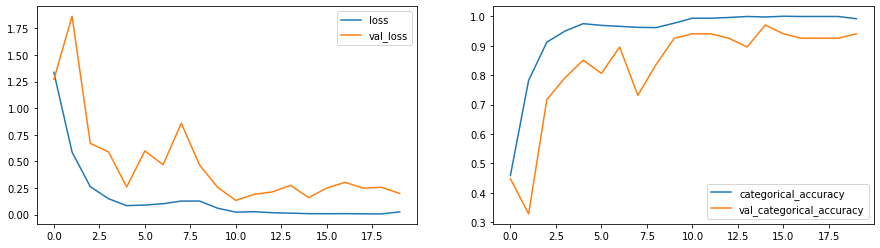

In [ ]:
plot_accuracy_and_loss(history_model5)

# Conclusion

>*   CNN+GRU cells along with Transfer Learning and data augmentation gave the good results considering parameter size, accuracy and loss functions trade-off.
*   Transfer learning boosted the overall accuracy of the model.
*   Findings:-
    1. No of parameters: 3693253
    2. Test Accuracy : 0.9200000166893005
    3. Test Loss: 0.23567628860473633




# Loading model and Testing

In [ ]:
import time
from keras.models import load_model
model = load_model('/content/model_init_2022-10-1517_21_04.769472/model-00011-0.02257-0.99329-0.13243-0.94030.h5')

In [ ]:
test_generator=RNNCNN_TL2()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=64,image_width=64)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=20)

g=test_generator.generator(test_generator.test_path,test_generator.test_doc,augment=False)
batch_data, batch_labels=next(g)

In [ ]:
batch_labels

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

1/1 [==============================] - 0s 34ms/step
[4 4 3 1 0 3 0 0 0 2 2 0 3 1 3 4 4 1 1 2 2 2 4 1 1 4 0 2 1 4 2 4]
